In [239]:
from mmdet3d.datasets import build_dataset
from tools.misc.browse_dataset import build_data_cfg
from mmdet3d.models import apply_3d_transformation
import matplotlib.pyplot as plt
import copy
import torch
import numpy as np
from mmdet3d.ops.voxel.voxelize import voxelization

In [240]:
config = "configs/_base_/datasets/nus-3d-1sweep-remove_close_develop_single.py"

In [241]:
config = "configs/_base_/datasets/nus-3d-1sweep-remove_close_develop_single.py"
cfg = build_data_cfg(config, ["Normalize"], None)
try:
    dataset = build_dataset(cfg.data.train, default_args=dict(filter_empty_gt=False))
except TypeError:  # seg dataset doesn't have `filter_empty_gt` key
    dataset = build_dataset(cfg.data.train)

In [242]:
def proj_points_to_2d(points, proj_mat):
    points = np.concatenate([points[:, :3].reshape(-1, 3), np.ones((points.shape[0], 1))], axis=-1)    
    points_2d = points @ proj_mat.T
    points_2d[:, 2] = np.clip(points_2d[:, 2], a_min=1e-5, a_max=1e5)
    points_2d[:, 0] /= points_2d[:, 2]
    points_2d[:, 1] /= points_2d[:, 2]
    return points_2d

def get_rgb(img):
    # Convert img to RGB
    img = img.int()
    img = img.flip(0) # BGR image, flip to RGB
    return img.permute(1, 2, 0) # Permute to (H, W, C)

### Build dataset from config

In [243]:
config = "configs/_base_/datasets/nus-3d-1sweep-remove_close_develop_single.py"
cfg = build_data_cfg(config, ["Normalize"], None)
try:
    dataset = build_dataset(cfg.data.train, default_args=dict(filter_empty_gt=False))
except TypeError:  # seg dataset doesn't have `filter_empty_gt` key
    dataset = build_dataset(cfg.data.train)

### Read data sample

In [244]:
cam_idx = 0
sample = dataset[0]
img_metas = sample["img_metas"].data
points = sample["points"].data
imgs = sample["img"].data
img = imgs[cam_idx]
proj_mat = img_metas['lidar2img'][cam_idx]

### Project lidar points to img

In [245]:
proj_mat = copy.deepcopy(proj_mat).reshape(4, 4)
if isinstance(proj_mat, torch.Tensor):
    proj_mat = proj_mat.cpu().numpy()

points_2d = proj_points_to_2d(points, proj_mat)

is_point_in_image = [(0 <= p[0] <= 1600) and (0 <= p[1] <= 900) for p in points_2d] 
points_2d_in_image = points_2d[is_point_in_image, :]
points_3d_in_image = points[is_point_in_image, :]

### Plot img and lidar points

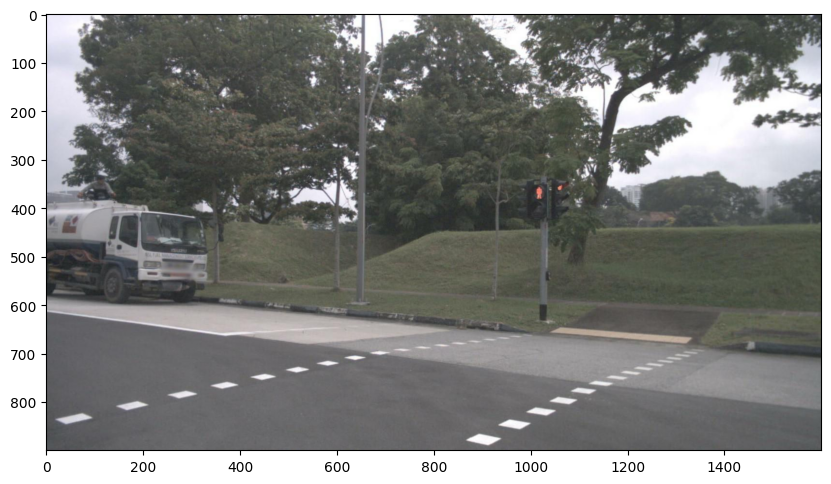

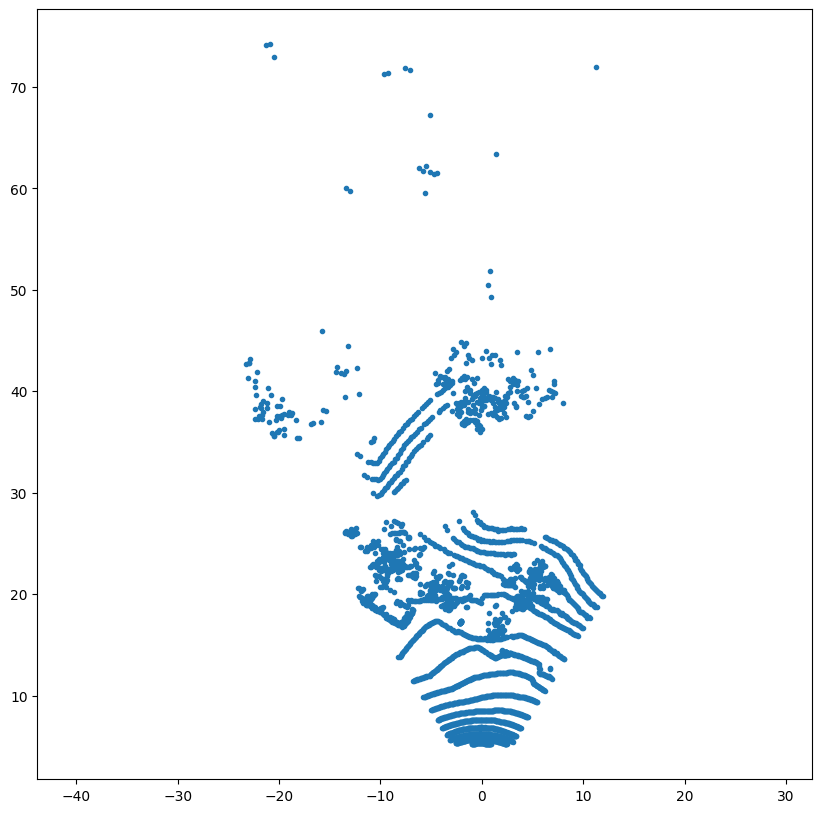

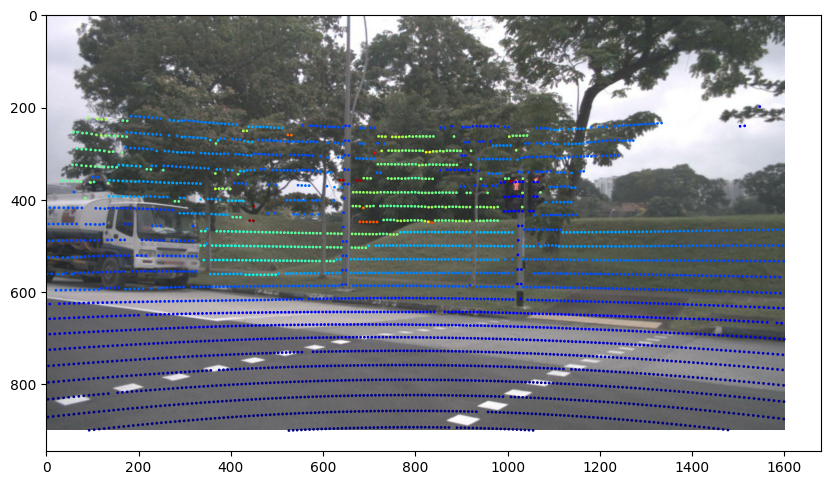

In [246]:
figsize = (10, 10)
rgb = get_rgb(img)
plt.figure(figsize=figsize)
plt.imshow(rgb)

plt.figure(figsize=figsize)
plt.plot(points_3d_in_image[:, 0], points_3d_in_image[:, 1], ".")
plt.axis("equal")
plt.show()

plt.figure(figsize=figsize)
plt.imshow(rgb)
plt.scatter(points_2d_in_image[:, 0], points_2d_in_image[:, 1], s=1, c=points_2d_in_image[:, 2], cmap="jet")
plt.show()

### Voxelize point cloud

In [247]:
voxel_size = 1.0
r = 50
point_cloud_range = (-r, -r, -5, r, r, 3)
voxels, voxel_coors, num_points_per_voxel = voxelization(points, (voxel_size, voxel_size, 8), point_cloud_range)
n_voxels_x = (point_cloud_range[3] - point_cloud_range[0])/voxel_size

### Plot voxel grid and non-empty voxels

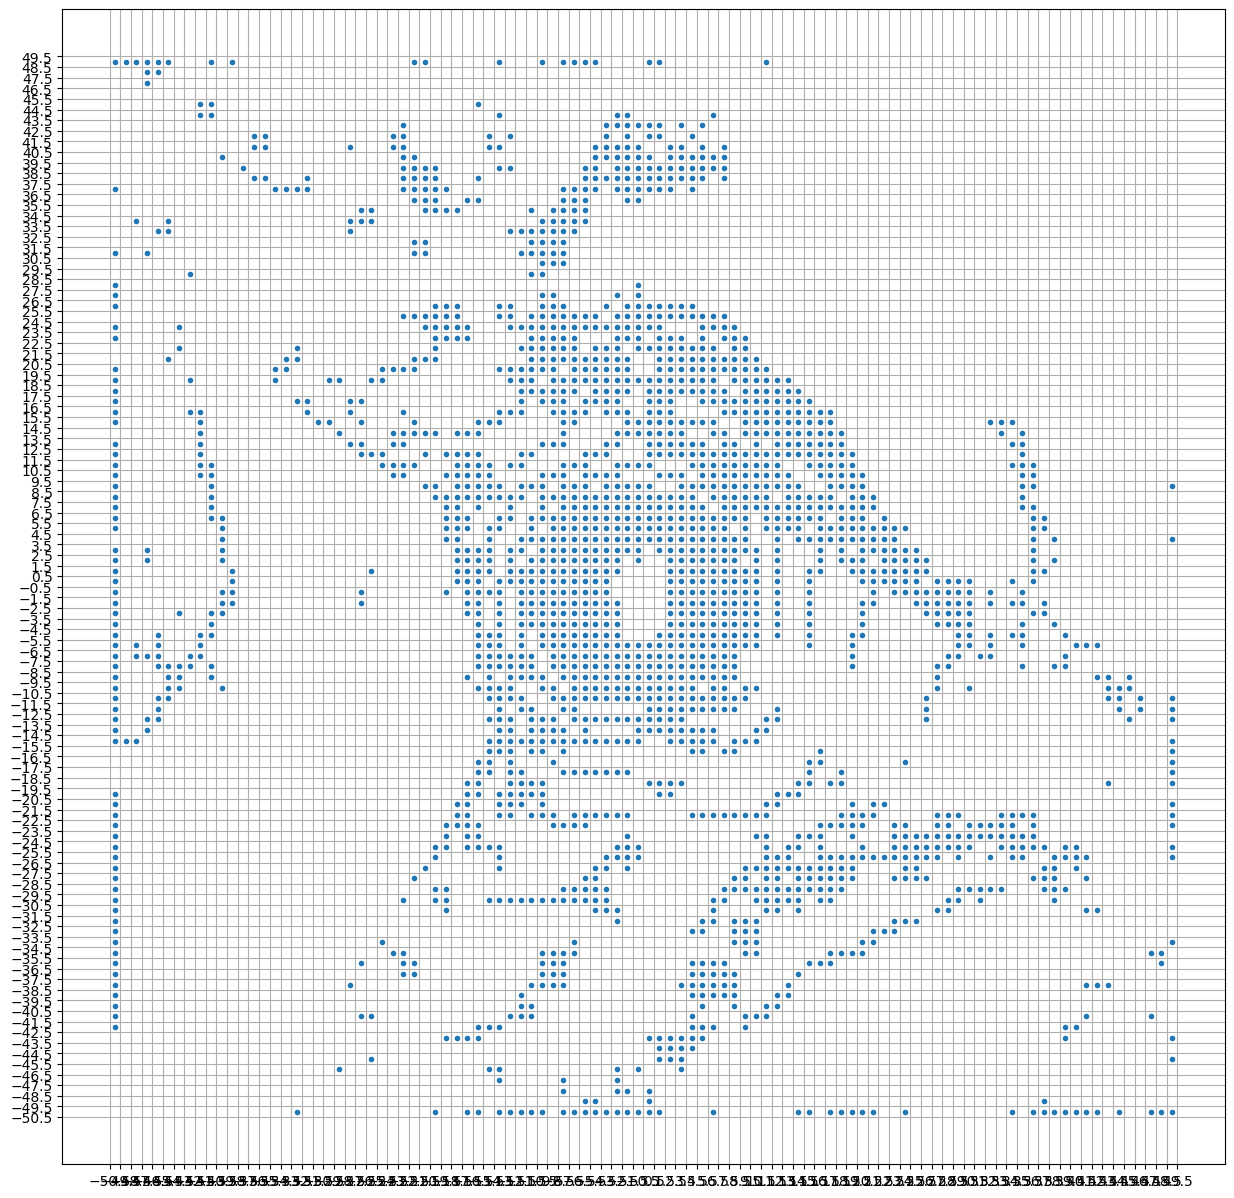

In [248]:
plt.figure(figsize=(15, 15))
plt.plot(voxel_coors[:, 2]-n_voxels_x/2, voxel_coors[:, 1]-n_voxels_x/2, ".")
plt.xticks(np.arange(-n_voxels_x/2, n_voxels_x/2 + 1, 1) - 0.5)
plt.yticks(np.arange(-n_voxels_x/2, n_voxels_x/2 + 1, 1) - 0.5)
plt.grid(True, which='major')
plt.show()

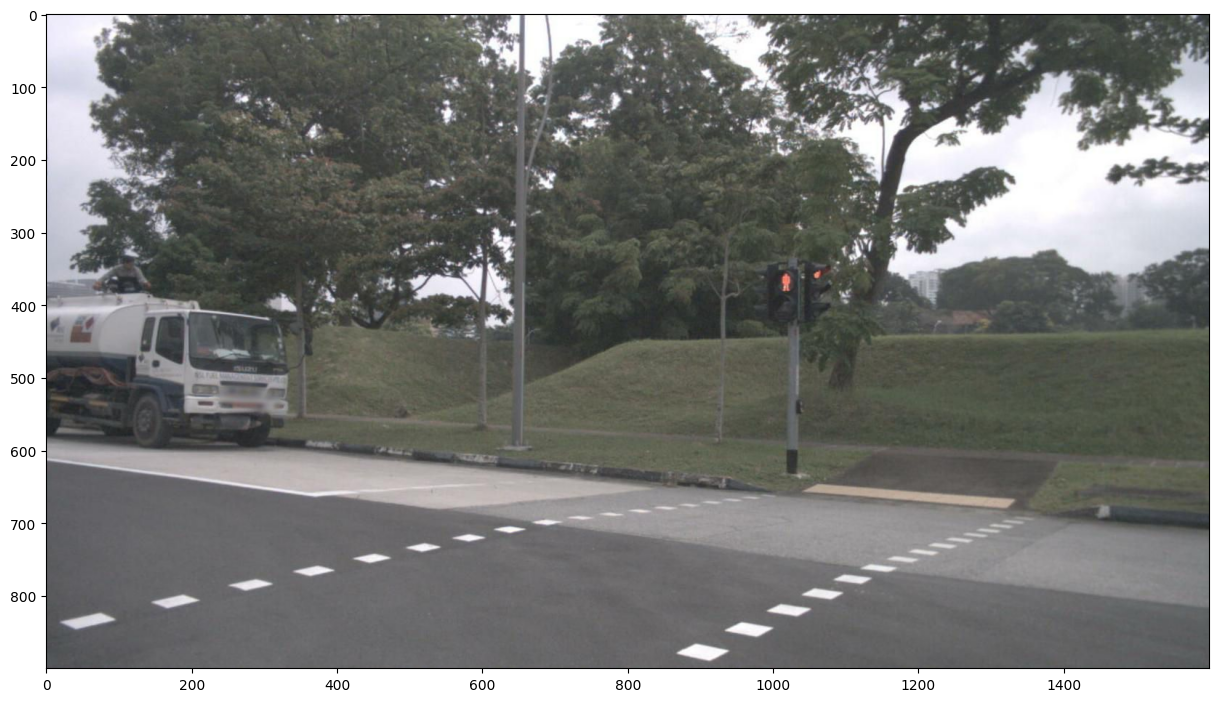

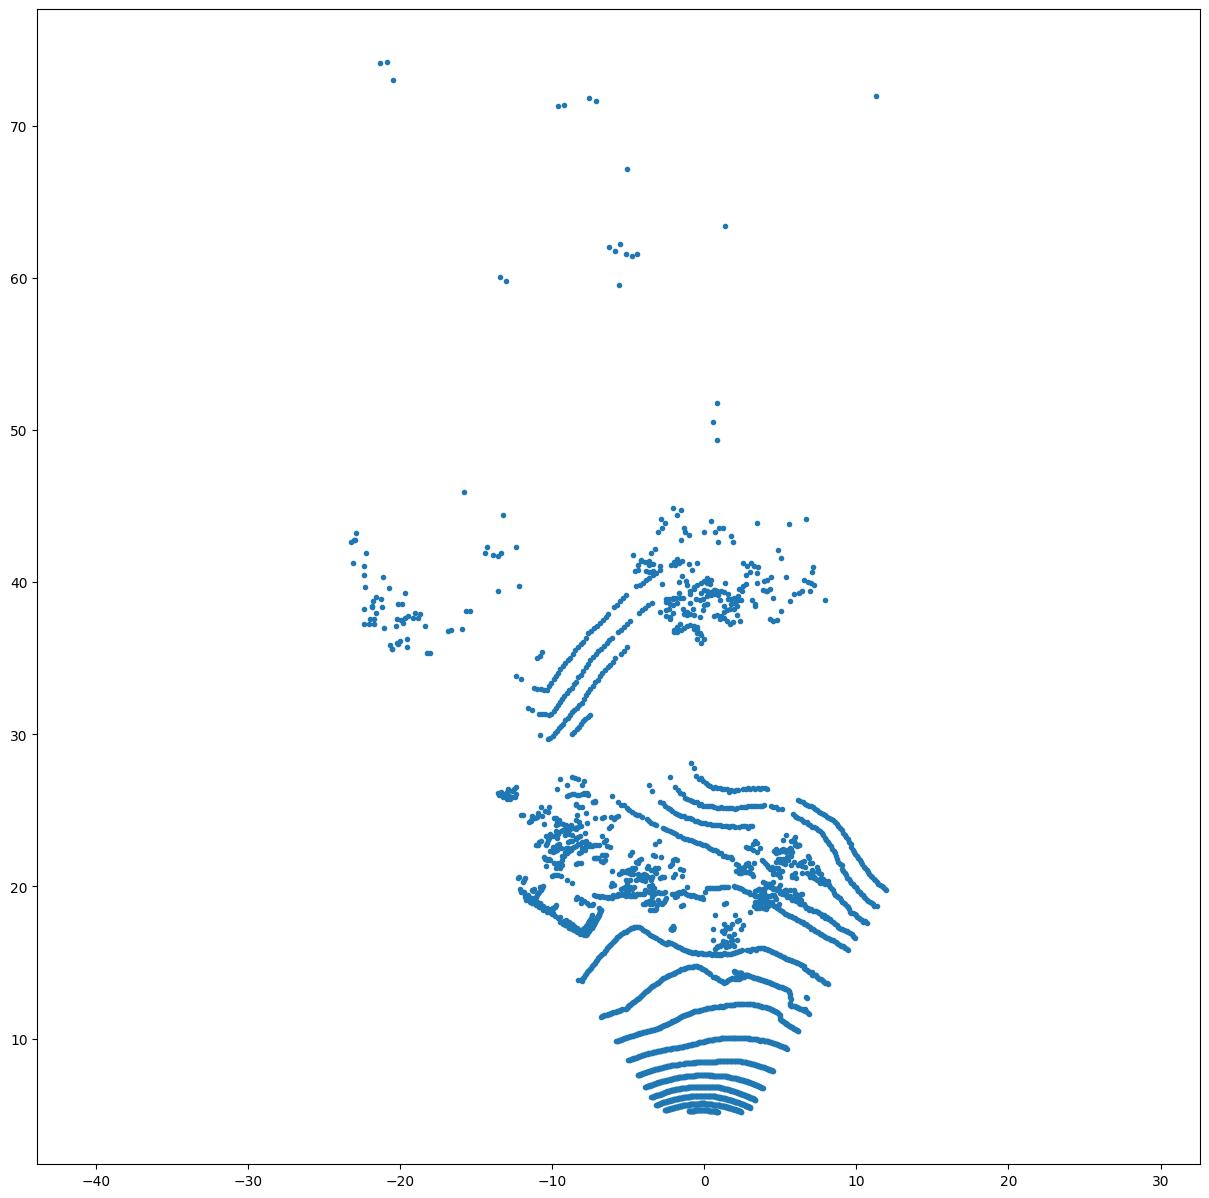

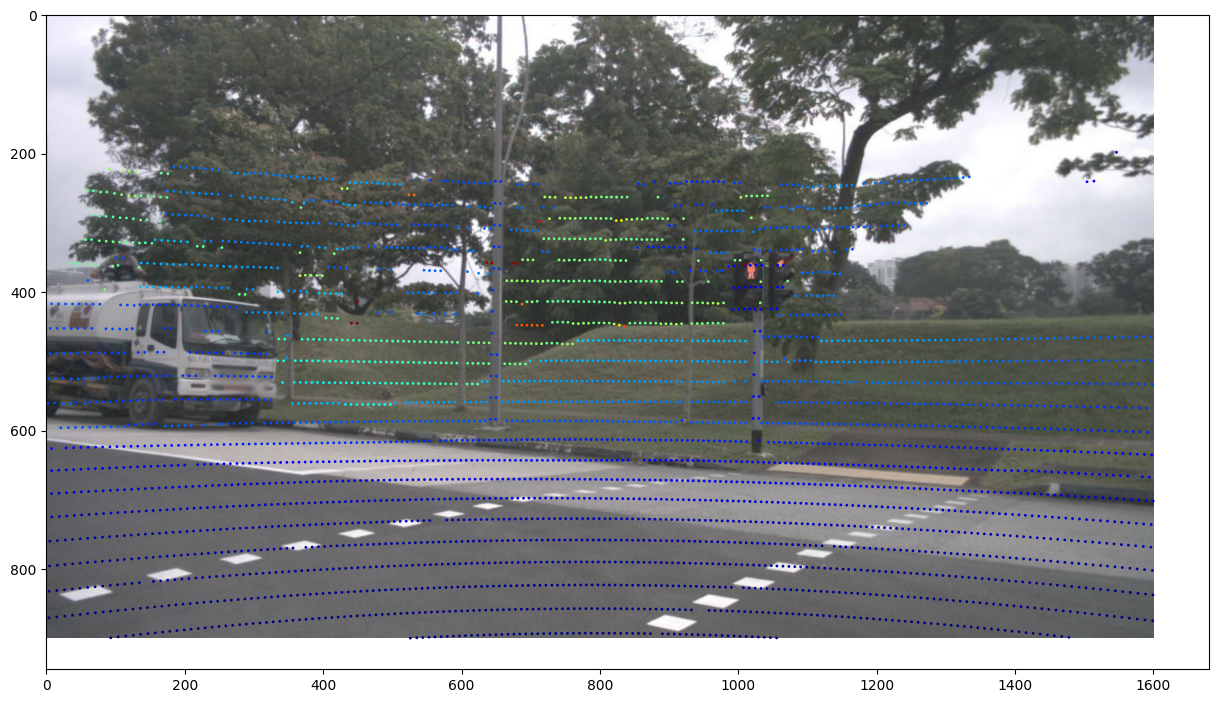

In [207]:
voxel_size = (0.5, 0.5, 8)
cam_idx = 0
sample = dataset[0]
img_metas = sample["img_metas"].data
points = sample["points"].data
imgs = sample["img"].data
img = imgs[cam_idx]
proj_mat = img_metas['lidar2img'][cam_idx]

proj_mat = copy.deepcopy(proj_mat).reshape(4, 4)
if isinstance(proj_mat, torch.Tensor):
    proj_mat = proj_mat.cpu().numpy()

points_2d = proj_points_to_2d(points, proj_mat)

rgb = get_rgb(img)
plt.figure(figsize=(15, 10))
plt.imshow(rgb)

is_point_in_image = [(0 <= p[0] <= 1600) and (0 <= p[1] <= 900) for p in points_2d] 
points_2d_in_image = points_2d[is_point_in_image, :]
points_3d_in_image = points[is_point_in_image, :]


voxel_size = 1.0
r = 50
point_cloud_range = (-r, -r, -5, r, r, 3)
voxels, voxel_coors, num_points_per_voxel = voxelization(points, (voxel_size, voxel_size, 8), point_cloud_range)

n_voxels_x = (point_cloud_range[3] - point_cloud_range[0])/voxel_size
plt.figure(figsize=(15, 15))
plt.plot(voxel_coors[:, 2]-n_voxels_x/2, voxel_coors[:, 1]-n_voxels_x/2, ".")
plt.xticks(np.arange(-n_voxels_x/2, n_voxels_x/2 + 1, 1) - 0.5)
plt.yticks(np.arange(-n_voxels_x/2, n_voxels_x/2 + 1, 1) - 0.5)
plt.grid(True, which='major')
plt.show()

###### PLOTS ######

plt.figure(figsize=(15,15))
plt.plot(points_3d_in_image[:, 0], points_3d_in_image[:, 1], ".")
plt.axis("equal")
plt.show()

plt.figure(figsize=(15,10))
plt.imshow(rgb)
plt.scatter(points_2d_in_image[:, 0], points_2d_in_image[:, 1], s=1, c=points_2d_in_image[:, 2], cmap="jet")
#plt.xlim([0, 1600])
#plt.ylim([0, 900])
plt.show()

In [188]:
from mmdet3d.ops.voxel.voxelize import voxelization

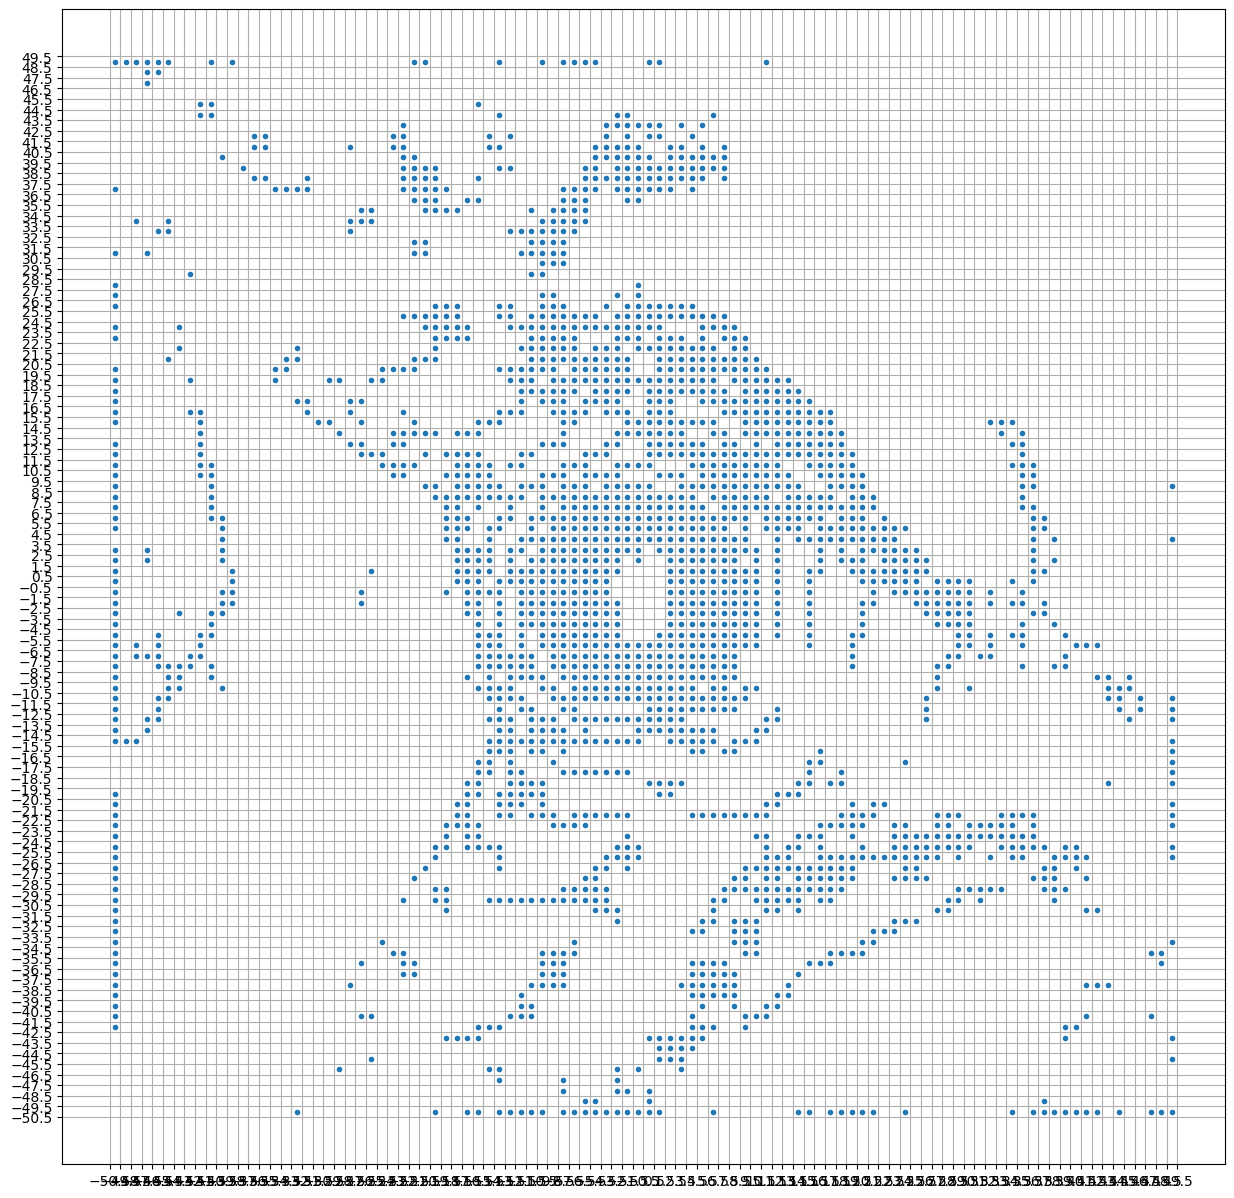

In [254]:
voxel_size = 1.0
r = 50
point_cloud_range = (-r, -r, -5, r, r, 3)
voxels, voxel_coors, num_points_per_voxel = voxelization(points, (voxel_size, voxel_size, 8), point_cloud_range)

n_voxels_x = (point_cloud_range[3] - point_cloud_range[0])/voxel_size
plt.figure(figsize=(15, 15))
plt.plot(voxel_coors[:, 2]-n_voxels_x/2, voxel_coors[:, 1]-n_voxels_x/2, ".")
plt.xticks(np.arange(-n_voxels_x/2, n_voxels_x/2 + 1, 1) - 0.5)
plt.yticks(np.arange(-n_voxels_x/2, n_voxels_x/2 + 1, 1) - 0.5)
plt.grid(True, which='major')
plt.show()